<img src="../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px\" align="left">

## Correlated Randomized Benchmarking
---

* **Last Updated:** June 20, 2020
* **Requires:** qiskit-terra 0.14, qiskit-ignis 0.3, qiskit-aer 0.5


## Introduction

**Randomization benchmarking (RB)** is a well-known technique to measure average gate performance by running sequences of random Clifford gates that should return the qubits to the initial state. 
Qiskit Ignis has tools to generate one- and two-qubit Clifford gate sequences simultaneously. If we run simultaneous RB we can look at the decay of correlated Z-Pauli's to extract the weight and locality of errors (see paper XXX).

This notebook gives an example for how to use the ``ignis.verification.randomized_benchmarking`` module to run correlated RB. This particular example shows how to run single qubit simultaneous randomized benchmarking on 5 qubits. 

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes classes
import qiskit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, coherent_unitary_error, thermal_relaxation_error, pauli_error, mixed_unitary_error

#Import the RB Functions
import os, sys
HOME = "/home/dekelm/Documents/⁨GitHub/⁨qiskit-ignis"
QISKIT_ROOT = HOME
root_dir = os.path.expanduser(QISKIT_ROOT)
if os.path.expanduser(QISKIT_ROOT) not in sys.path:
    sys.path = [os.path.expanduser(QISKIT_ROOT)] + sys.path
import qiskit.ignis.verification.randomized_benchmarking as rb
print(rb.__file__)

#Import the RB Functions
#import qiskit.ignis.verification.randomized_benchmarking as rb

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

/Users/dekelm/opt/anaconda3/lib/python3.7/site-packages/qiskit/ignis/verification/randomized_benchmarking/__init__.py


### Select the Parameters of the RB Run

First, wee need to choose the following parameters:

- **nseeds:** The number of seeds. For each seed there you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In this example we have 4 qubits Q0,Q1,Q2,Q3. 
We are running 1Q RB (on each qubit) simultaneously, 

In [3]:
##### Number of qubits. There are 4 qubits: Q0,Q1,Q2,Q3.
nQ = 4
#Number of seeds (random sequences)
nseeds = 5 #set to 5 for testing
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = list(np.arange(1,1200,75))
nCliffs.append(1800)

#1Q RB on Q0-3 simultaneously
rb_pattern = [[0],[1],[2],[3]]
basis_gates = ['u1', 'u2', 'u3', 'cx']

In [4]:
#load the backend
backend = qiskit.Aer.get_backend('qasm_simulator')

# create noise model
# create ZZ noise between each qubit to qubit 2
noise_model = NoiseModel()

zz_unitary = np.eye(4,dtype=complex)
zz_unitary[3,3] = -1
error = coherent_unitary_error(zz_unitary)

noise_model.add_nonlocal_quantum_error(error, basis_gates, [0], [0, 2])
noise_model.add_nonlocal_quantum_error(error, basis_gates, [1], [1, 2])
noise_model.add_nonlocal_quantum_error(error, basis_gates, [3], [3, 2])
noise_model.add_nonlocal_quantum_error(error, basis_gates, [2], [2, 0])
noise_model.add_nonlocal_quantum_error(error, basis_gates, [2], [2, 1])
noise_model.add_nonlocal_quantum_error(error, basis_gates, [2], [2, 3])

# Add T1/T2 noise to the simulation
t_1 = 50
t_2 = 90
gate1q = 0.1
gate2q = 0.5
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t_1, t_2, gate1q), 'u2')
noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t_1, t_2, 2 * gate1q), 'u3')
noise_model.add_all_qubit_quantum_error(
    thermal_relaxation_error(t_1, t_2, gate2q).tensor(thermal_relaxation_error(t_1, t_2, gate2q)), 'cx')

### Create and run the measurement calibration

Measurement correction is needed because we want to measure the correlations during RB independent of any measurement correlations

In [5]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(4)
qubit_list = []
for i in rb_pattern:
    for j in i:
        qubit_list.append(j)
print(qubit_list)
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

[0, 1, 2, 3]


In [6]:
shots = 1024
meas_calibs_trans = qiskit.compiler.transpile(meas_calibs, 
                                              backend=backend, 
                                              basis_gates=basis_gates, optimization_level=0)
qobj = qiskit.compiler.assemble(meas_calibs_trans, shots=shots)
job = backend.run(qobj)

In [7]:
# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(job.result(), state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


In [8]:
# Get the filter object
meas_filter = meas_fitter.filter

## Generate RB sequences

We generate RB sequences. We start with a small example (so it doesn't take too long to run).

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function **rb.randomized_benchmarking_seq**.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).
- **rb_opts_dict:** Option dictionary back out with default options appended.

In [9]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [10]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_circs, xdata = rb.randomized_benchmarking_seq(**rb_opts)

As an example, we print the circuit corresponding to the first RB sequence

In [11]:
print(rb_circs[0][0])

      ┌─────┐ ┌───┐   ░  ┌───┐┌───┐     ┌─┐                          
qr_0: ┤ SDG ├─┤ H ├───░──┤ H ├┤ S ├─────┤M├──────────────────────────
      ├─────┤ ├───┤ ┌───┐└─░─┘├───┤┌───┐└╥┘ ┌───┐      ┌─┐           
qr_1: ┤ SDG ├─┤ H ├─┤ Z ├──░──┤ Z ├┤ H ├─╫──┤ S ├──────┤M├───────────
      └┬───┬┘ ├───┤ ├───┤┌───┐└─░─┘├───┤ ║ ┌┴───┴┐┌───┐└╥┘┌───┐┌─┐   
qr_2: ─┤ H ├──┤ H ├─┤ S ├┤ Z ├──░──┤ Z ├─╫─┤ SDG ├┤ H ├─╫─┤ H ├┤M├───
       ├───┤ ┌┴───┴┐├───┤├───┤  ░  ├───┤ ║ └┬───┬┘├───┤ ║ ├───┤└╥┘┌─┐
qr_3: ─┤ H ├─┤ SDG ├┤ H ├┤ Z ├──░──┤ Z ├─╫──┤ H ├─┤ S ├─╫─┤ H ├─╫─┤M├
       └───┘ └─────┘└───┘└───┘  ░  └───┘ ║  └───┘ └───┘ ║ └───┘ ║ └╥┘
cr_0: ═══════════════════════════════════╩══════════════╬═══════╬══╬═
                                                        ║       ║  ║ 
cr_1: ══════════════════════════════════════════════════╩═══════╬══╬═
                                                                ║  ║ 
cr_2: ══════════════════════════════════════════════════════════╩══╬═
                    

## Execute RB Circuits

We can execute the RB sequences using IBMQ provider, 
and obtain a list of results **result_list**.

In [12]:
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
# run the noisy simulation (with fixed seed)
results = []
for circ_ind, circuit in enumerate(rb_circs):
    results.append(qiskit.execute(circuit, backend=backend,
                                      basis_gates=basis_gates,
                                      shots=shots,
                                      noise_model=noise_model,
                                      seed_simulator=42).result())   
    print("finished seed %s" % str(circ_ind))
print("Finished Running")

finished seed 0
finished seed 1
finished seed 2
finished seed 3
finished seed 4
Finished Running


## Get statistics about the survival probabilities

The results in **results_list** should fit to an exponentially decaying function $A \cdot \alpha ^ m + B$, where $m$ is the Clifford length.

We fit to each of the correlators.

### Fit the RB data to get the decay parameters "alpha"

In [13]:
#correct results
result_corr = []
for result in results:
    result_corr.append(meas_filter.apply(result))

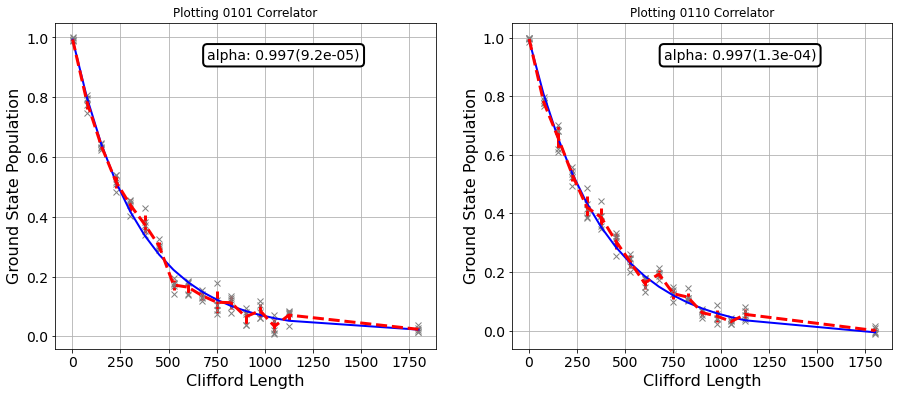

In [16]:
rbfit = CorrelatedRBFitter(None, xdata, rb_opts['rb_pattern'])

for seed_num, data in enumerate(result_corr):
    
    # Add another seed to the data
    if seed_num>-1:
        rbfit.add_data([data],rerun_fit=False)
        
rbfit.calc_data()
rbfit.calc_statistics()
rbfit.fit_data()

plt.figure(figsize=(15, 6))
axis = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    
for i,j in enumerate(np.arange(4,6)):
    pattern_ind = j

    # Plot the essence by calling plot_rb_data
    rbfit.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

In [18]:
#These are the decay parameters from the fit
rbfit.fit_alphas

{'0001': 0.9985458443048726,
 '0010': 0.9984631025845568,
 '0011': 0.9971586885342325,
 '0100': 0.998568183503602,
 '0101': 0.9970297056462039,
 '0110': 0.99731599706991,
 '0111': 0.9965745045862572,
 '1000': 0.9974797099413649,
 '1001': 0.9961514599065715,
 '1010': 0.9964864718804591,
 '1011': 0.9964947170616795,
 '1100': 0.9977875137195451,
 '1101': 0.9968160662977542,
 '1110': 0.9963242449314207,
 '1111': 0.9951569138465949}

### Fit the alphas to a depolarizing map

In [19]:
rbfit.fit_alphas_to_epsilon()

6.06536845462737e-07

In [20]:
rbfit.fit_epsilon

{'0001': [0.0006210574215673116, 0.0002853254293253389],
 '0010': [0.0006690245105200312, 0.0002853048973461154],
 '0011': [0.0004924791664550019, 0.0004033784366100691],
 '0100': [0.00013201350759463627, 0.0002855348778925304],
 '0101': [6.265898937574428e-09, 0.0004037352059958177],
 '0110': [1.2110820057522435e-10, 0.0004037255302349513],
 '0111': [6.760881459712265e-15, 0.0005707066705836864],
 '1000': [0.0007148167719152575, 0.00028528529965311913],
 '1001': [0.00027478593418101785, 0.00040347898443414697],
 '1010': [9.983872712463694e-07, 0.0004036073950073656],
 '1011': [1.1340833027119656e-06, 0.0005705003864648628],
 '1100': [0.0006761323167991203, 0.0004033752047426928],
 '1101': [0.0001804629297290642, 0.00057051245153062],
 '1110': [0.000489063542585209, 0.0005703397096293172],
 '1111': [1.3189223758909878e-07, 0.0007810842908622305]}

In [21]:
#These are the calculated decay parameters given the depolarizing probabilities 
#that the fitter returned
rbfit._calc_alphas([rbfit.fit_epsilon[i][0] for i in rbfit._subsystems])

array([0.99843081, 0.99834807, 0.99727387, 0.99852291, 0.99713612,
       0.99736132, 0.99646801, 0.99766455, 0.99655391, 0.99650609,
       0.99588719, 0.99753284, 0.99642235, 0.99637453, 0.99575572])

Text(0.5, 1.0, 'Qubits [0, 1, 2, 3] on Backend qasm_simulator')

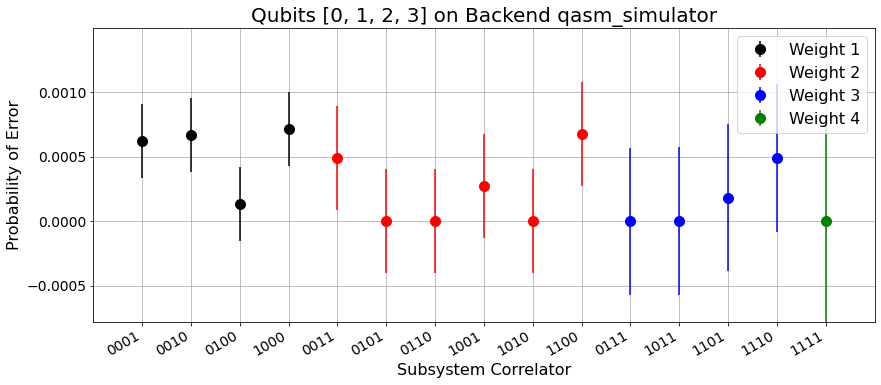

In [22]:
#Plot the depolarizing probabilities
fig = plt.figure(figsize=(14, 6))
rbfit.plot_epsilon(ax=fig.gca())
fig.gca().set_title("Qubits %s on Backend %s"%(str(qubit_list),backend.name()), fontsize=20)

### for comparison - run with different noise model.
set the ZZ error only between qubits 2 and 3.
the rest will be the same - same RB circuits and same thermal error

In [23]:
noise_model2 = NoiseModel()

noise_model2.add_nonlocal_quantum_error(error, basis_gates, [2], [2, 3])
noise_model2.add_nonlocal_quantum_error(error, basis_gates, [3], [3, 2])


# Add T1/T2 noise to the simulation
t_1 = 50
t_2 = 90
gate1q = 0.1
gate2q = 0.5
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t_1, t_2, gate1q), 'u2')
noise_model2.add_all_qubit_quantum_error(thermal_relaxation_error(t_1, t_2, 2 * gate1q), 'u3')
noise_model2.add_all_qubit_quantum_error(
    thermal_relaxation_error(t_1, t_2, gate2q).tensor(thermal_relaxation_error(t_1, t_2, gate2q)), 'cx')

In [24]:
results2 = []
for circ_ind, circuit in enumerate(rb_circs):
    results2.append(qiskit.execute(circuit, backend=backend,
                                      basis_gates=basis_gates,
                                      shots=shots,
                                      noise_model=noise_model2,
                                      seed_simulator=42).result())   
    print("finished seed %s" % str(circ_ind))
print("Finished Running")

finished seed 0
finished seed 1
finished seed 2
finished seed 3
finished seed 4
Finished Running


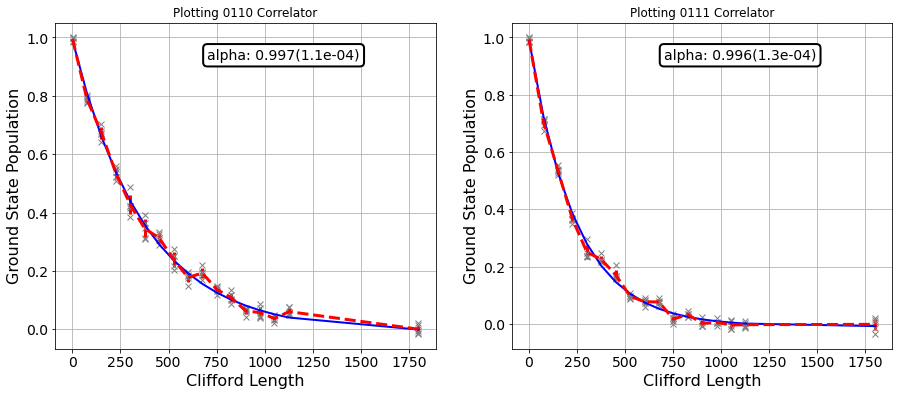

In [25]:
#correct results
result_corr2 = []
for result in results2:
    result_corr2.append(meas_filter.apply(result))

rbfit2 = CorrelatedRBFitter(result_corr2, xdata, rb_opts['rb_pattern'])

plt.figure(figsize=(15, 6))
axis = [plt.subplot(1, 2, 1), plt.subplot(1, 2, 2)]
    
for i,j in enumerate(np.arange(5,7)):
    pattern_ind = j

    # Plot the essence by calling plot_rb_data
    rbfit2.plot_rb_data(pattern_ind, ax=axis[i], add_label=True, show_plt=False)

Text(0.5, 1.0, 'Qubits [0, 1, 2, 3] on Backend qasm_simulator')

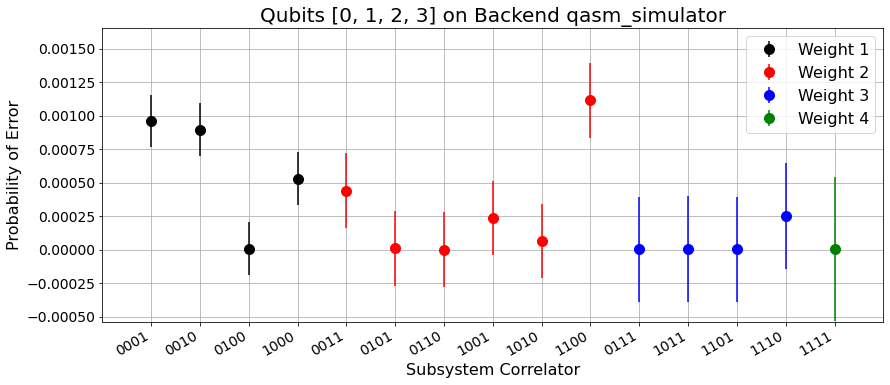

In [26]:
rbfit2.fit_alphas
rbfit2.fit_alphas_to_epsilon()
#Plot the depolarizing probabilities
fig = plt.figure(figsize=(14, 6))
rbfit2.plot_epsilon(ax=fig.gca())
fig.gca().set_title("Qubits %s on Backend %s"%(str(qubit_list),backend.name()), fontsize=20)